<a href="https://colab.research.google.com/github/leonardevop/mvp_2/blob/main/MVP2a.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MVP - Machine Learning
## Aluno: Leonard Ravaglia Pereira

### MBA - Ciência de Dados - PUC-RJ

# Definição do Problema

Como descobrir o setor da profissão exercida por um cidadão estadunidense?

Buscando responder essa pergunta, este trabalho busca extrair informações de um dataset de renda anual de cidadãos americanos, que contempla informações como renda, residência, idade, estado civil, grau de instrução, entre outros.

Utilizaremos modelos de classificação supervisionada para indicar os resultados.




In [2]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
from datetime import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

## Carga do Dataset

In [4]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/leonardevop/mvp_2/main/income.csv"
# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,40,Self-emp-not-inc,223881,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,70,United-States,>50K
1,30,Private,149118,HS-grad,9,Divorced,Craft-repair,Not-in-family,White,Female,0,0,40,United-States,<=50K
2,46,Private,109209,Some-college,10,Married-civ-spouse,Adm-clerical,Husband,White,Male,0,0,40,United-States,>50K
3,32,Private,229566,Assoc-voc,11,Married-civ-spouse,Other-service,Husband,White,Male,0,0,60,United-States,>50K
4,54,?,148657,Preschool,1,Married-civ-spouse,?,Wife,White,Female,0,0,40,Mexico,<=50K


In [5]:
#Visualizando últimos registros
dataset.tail()

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
24995,40,Private,130834,Some-college,10,Never-married,Adm-clerical,Not-in-family,White,Female,0,0,40,United-States,<=50K
24996,31,Local-gov,33124,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,50,United-States,<=50K
24997,38,Federal-gov,190895,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,?,>50K
24998,23,Private,420973,Bachelors,13,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,40,United-States,<=50K
24999,60,Private,88055,10th,6,Married-civ-spouse,Transport-moving,Husband,White,Male,0,0,40,United-States,<=50K


In [6]:
#Identificando as opções de setores do target
print(dataset.workclass.unique())

['Self-emp-not-inc' 'Private' '?' 'Local-gov' 'Self-emp-inc' 'State-gov'
 'Federal-gov' 'Without-pay' 'Never-worked']


In [7]:
#Preenchendo valores de Renda suspeita
suspeito = dataset['workclass'].replace('?', 'Suspicious')
dataset['workclass'] = suspeito

In [68]:
#Verificando tipos de dados dos atributos
dataset.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education.num      int64
marital.status    object
occupation        object
relationship      object
race              object
sex               object
capital.gain       int64
capital.loss       int64
hours.per.week     int64
native.country    object
income            object
dtype: object

In [9]:
#Checando total de registros
dataset.count()

age               25000
workclass         25000
fnlwgt            25000
education         25000
education.num     25000
marital.status    25000
occupation        25000
relationship      25000
race              25000
sex               25000
capital.gain      25000
capital.loss      25000
hours.per.week    25000
native.country    25000
income            25000
dtype: int64

Notamos que o dataset não contém dados em branco, e que há 9 setores possíveis para classificação.
Há ainda um setor não informado, o qual, para fins de estudo, trataremos como uma fonte de renda suspeita.

Nessa etapa, fazemos um pré-processamento, convertendo as colunas categóricas para one-hot-encoding.

In [10]:
#Convertendo as colunas categóricas em one-hot-encoding
df = pd.get_dummies(data=dataset, columns=['education', 'education.num', 'marital.status', 'occupation', 'relationship', 'race', 'sex', 'native.country', 'income'])

#movendo coluna target para o final do dataset
coluna_target = df.pop('workclass')
df.insert(len(df.columns),'workclass',coluna_target)

In [56]:
print(df.shape)

(25000, 116)


# Separação de conjunto de teste

Manteremos os critérios definidos no notebook apresentado em aula, com o mesmo seed para garantir o padrão do código.

In [11]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória utilizada para garantir o mesmo resultado

# Separação em conjuntos de treino e teste
array = df.values
X = array[:, 0:len(df.columns) -1]
y = array[:, len(df.columns) -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

Nessa etapa, testamos os modelos individuais e essembles apresentados, utilizando a métrica de acurácia e o apresentando ao final, junto com o desvio padrão calculado.

LR: 0.698500 (0.000894)
KNN: 0.667050 (0.003252)
CART: 0.646350 (0.006679)
NB: 0.421350 (0.038495)
SVM: 0.698850 (0.000229)
Bagging: 0.755800 (0.005269)
RF: 0.748650 (0.004517)
ET: 0.727900 (0.006032)
Ada: 0.724300 (0.016193)
GB: 0.765150 (0.006136)
Voting: 0.698900 (0.000436)


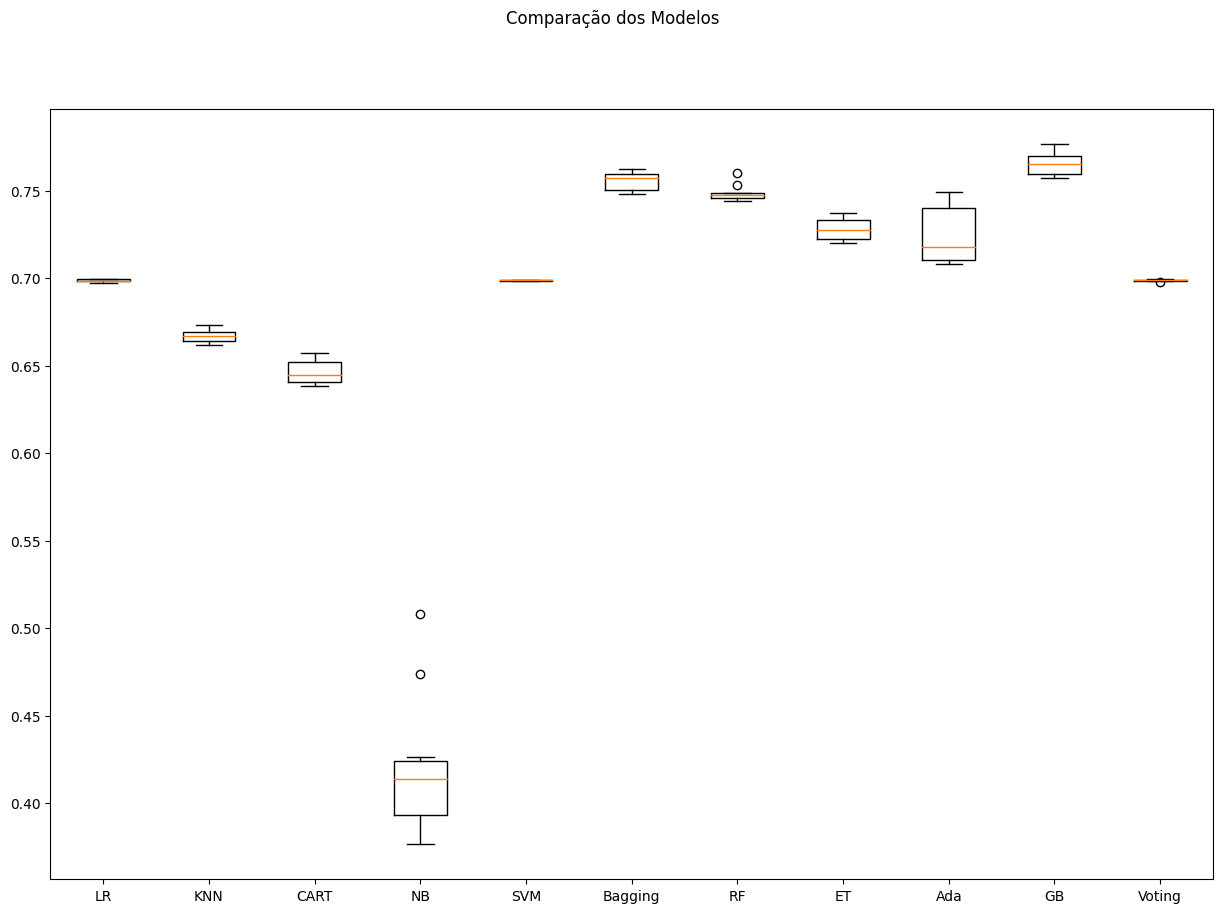

In [12]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LogisticRegression(max_iter=200)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Definindo os parâmetros do classificador base para o BaggingClassifier
base = DecisionTreeClassifier()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingClassifier
bases = []
model1 = LogisticRegression(max_iter=200)
bases.append(('logistic', model1))
model2 = DecisionTreeClassifier()
bases.append(('cart', model2))
model3 = SVC()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingClassifier(base_estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostClassifier(n_estimators=num_trees)))
models.append(('GB', GradientBoostingClassifier(n_estimators=num_trees)))
models.append(('Voting', VotingClassifier(bases)))

# Listas para armazenar os resultados
results = []
names = []


# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, error_score='raise')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()


Nessa momento, identificamos que o modelo de Gradient Boosting apresentou o melhor resultado.
Na próxima etapa, realizaremos a padronização e normalização dos dados para verificar se o desempenho se mantém.

### Criação e avaliação de modelos: dados padronizados e normalizados

LR-orig: 0.699 (0.001)
KNN-orig: 0.667 (0.003)
CART-orig: 0.646 (0.007)
NB-orig: 0.421 (0.038)
SVM-orig: 0.699 (0.000)
Bag-orig: 0.756 (0.005)
RF-orig: 0.749 (0.005)
ET-orig: 0.728 (0.006)
Ada-orig: 0.724 (0.016)
GB-orig: 0.765 (0.006)
Vot-orig: 0.699 (0.000)
LR-padr: 0.764 (0.004)
KNN-padr: 0.736 (0.008)
CART-padr: 0.649 (0.009)
NB-padr: 0.098 (0.005)
SVM-padr: 0.761 (0.004)
Bag-padr: 0.756 (0.004)
RF-padr: 0.748 (0.005)
ET-padr: 0.727 (0.007)
Ada-padr: 0.724 (0.016)
GB-padr: 0.765 (0.006)
Vot-padr: 0.766 (0.003)
LR-norm: 0.764 (0.004)
KNN-norm: 0.735 (0.008)
CART-norm: 0.646 (0.009)
NB-norm: 0.103 (0.005)
SVM-norm: 0.765 (0.005)
Bag-norm: 0.756 (0.006)
RF-norm: 0.748 (0.005)
ET-norm: 0.728 (0.006)
Ada-norm: 0.724 (0.016)
GB-norm: 0.765 (0.006)
Vot-norm: 0.765 (0.004)


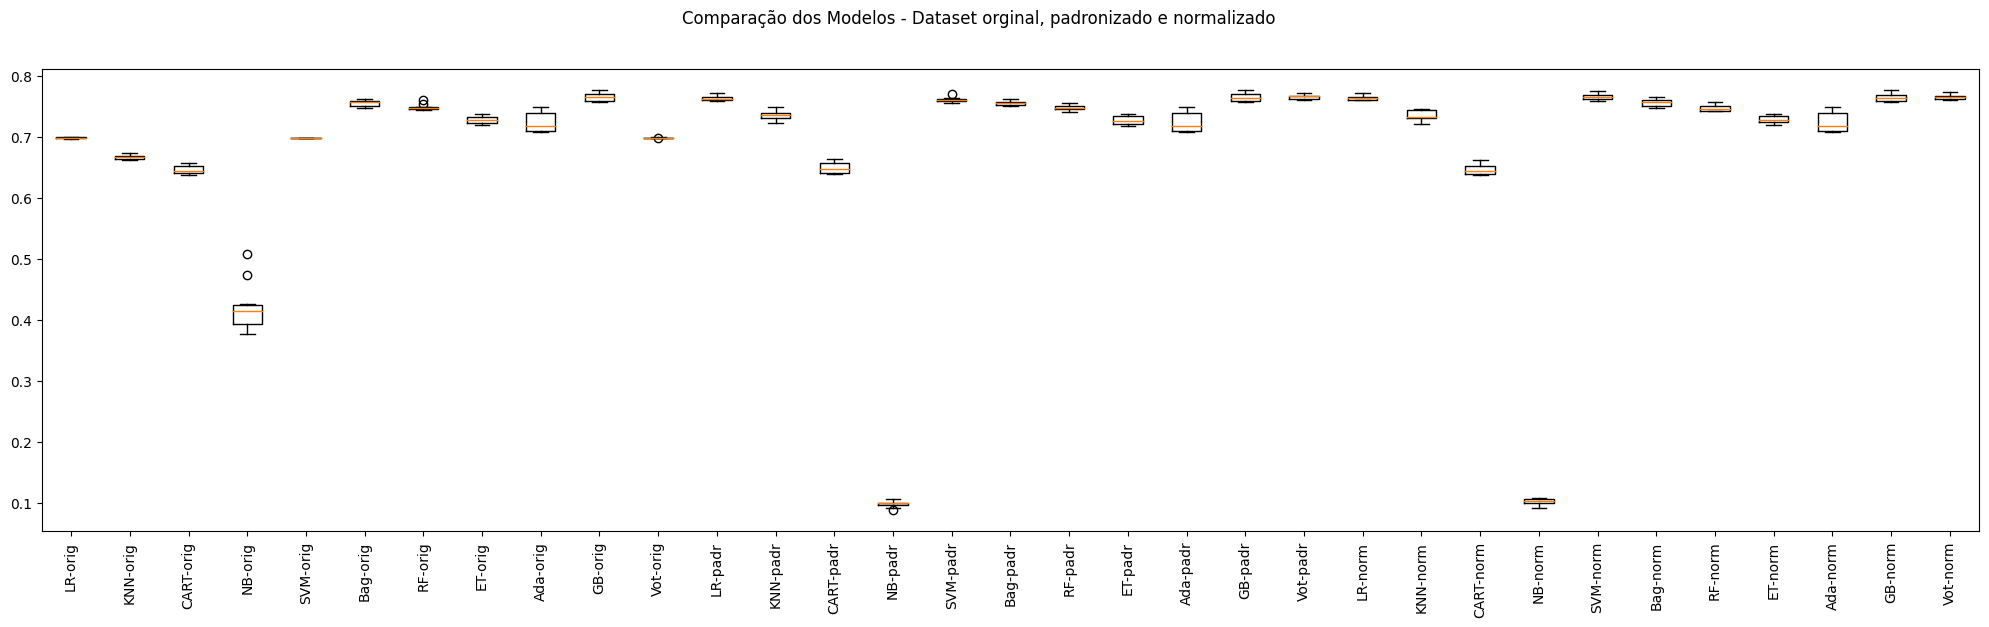

In [13]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LogisticRegression(max_iter=200))
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())
bagging = ('Bag', BaggingClassifier(base_estimator=base, n_estimators=num_trees))
random_forest = ('RF', RandomForestClassifier(n_estimators=num_trees, max_features=max_features))
extra_trees = ('ET', ExtraTreesClassifier(n_estimators=num_trees, max_features=max_features))
adaboost = ('Ada', AdaBoostClassifier(n_estimators=num_trees))
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
voting = ('Voting', VotingClassifier(bases))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

Com a normaliação e padronização dos dados, grande parte dos modelos melhorou seus resultados, com exceção do próprio Gradient Boosting que se manteve no mesmo nível.

Seguiremos com esse modelo para as etapas seguintes, alterando os seus hiperparâmetros, através da alteração do número árvores de classificação. Tendo em vista que os modelos normalizados e padronizados do Gradient Boosting se mantiveram no mesmo nível, utilizaremos apenas o modelo normalizado para as próximas etapas.

### Otimização dos hiperparâmetros

In [20]:
# Tuning do Gradient Boosting

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
gradient_boosting = ('GB', GradientBoostingClassifier(n_estimators=num_trees))
#standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

#pipelines.append(('GB-orig', Pipeline(steps=[gradient_boosting])))
#pipelines.append(('GB-padr', Pipeline(steps=[standard_scaler, gradient_boosting])))
pipelines.append(('GB-norm', Pipeline(steps=[min_max_scaler, gradient_boosting])))

param_grid = {
    'GB__n_estimators': [80, 120],
    #'GB__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: GB-norm - Melhor: 0.765650 usando {'GB__n_estimators': 120}


Percebemos que  alteração do número de árvores para 80 e 120 árvores não melhoraram a acurácia do modelo.

## Finalização do Modelo

In [21]:
# Avaliação do modelo com o conjunto de testes
num_trees = 100

# Preparação do modelo
scaler = MinMaxScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = GradientBoostingClassifier(n_estimators=num_trees)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.7668


A base de teste apresentou uma acurácia melhor do que o de treinamento, porém bem próxima, como previsto.

In [22]:
# Preparação do modelo com TODO o dataset
scaler = MinMaxScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

GradientBoostingClassifier()

## Simulando a aplicação do modelo em dados não vistos

Vamos testar o modelo com dados simulados, para 6 instâncias.
O teste buscará identificar em qual setor trabalham os cidadãos.

Os únicos parâmetros alterados foram de raça, sexo.

Dado que existe uma relação entre o setor e atributo da ocupação exercida, foi utilizada uma ocupação que poderia ser distribuída em outros setores.

Para aprimorar o modelo, alguns atributos poderiam ser excluídos do dataset na etapa de pré-processamento, ou ajustado o processo de seleção de características.

In [67]:
# Novos dados
data = {'education_HS-grad': [1, 1, 1, 1, 1, 1],
        'fnlwgt': [1484710, 1455435, 721712, 19214, 30000, 65000],
        'capital.gain': [0, 0, 0, 0, 0, 0],
        'capital.loss': [0, 0, 0, 0, 0, 0],
        'education_10th': [0, 0, 0, 0, 0, 0],
        'education_11th': [0, 0, 0, 0, 0, 0],
        'education_12th': [0, 0, 0, 0, 0, 0],
        'education_1st-4th': [0, 0, 0, 0, 0, 0],
        'education_5th-6th': [0, 0, 0, 0, 0, 0],
        'education_7th-8th': [0, 0, 0, 0, 0, 0],
        'education_9th': [0, 0, 0, 0, 0, 0],
        'education_Assoc-acdm': [0, 0, 0, 0, 0, 0],
        'education_Assoc-voc': [0, 0, 0, 0, 0, 0],
        'education_Bachelors': [0, 0, 0, 0, 0, 0],
        'education_Doctorate': [0, 0, 0, 0, 0, 0],
        'education_Masters': [0, 0, 0, 0, 0, 0],
        'education_Preschool': [0, 0, 0, 0, 0, 0],
        'education_Prof-school': [0, 0, 0, 0, 0, 0],
        'education_Some-college': [0, 0, 0, 0, 0, 0],
        'education.num_1': [0, 0, 0, 0, 0, 0],
        'education.num_2': [0, 0, 0, 0, 0, 0],
        'education.num_3': [0, 0, 0, 0, 0, 0],
        'education.num_4': [0, 0, 0, 0, 0, 0],
        'education.num_5': [0, 0, 0, 0, 0, 0],
        'education.num_6': [0, 0, 0, 0, 0, 0],
        'education.num_7': [0, 0, 0, 0, 0, 0],
        'education.num_8': [0, 0, 0, 0, 0, 0],
        'education.num_9': [1, 1, 1, 1, 1, 1],
        'education.num_11': [0, 0, 0, 0, 0, 0],
        'education.num_12': [0, 0, 0, 0, 0, 0],
        'education.num_13': [0, 0, 0, 0, 0, 0],
        'education.num_14': [0, 0, 0, 0, 0, 0],
        'education.num_15': [0, 0, 0, 0, 0, 0],
        'education.num_16': [0, 0, 0, 0, 0, 0],
        'marital.status_Divorced': [0, 0, 0, 0, 0, 0],
        'marital.status_Married-AF-spouse': [0, 0, 0, 0, 0, 0],
        'marital.status_Married-civ-spouse': [1, 1, 1, 1, 1, 1],
        'marital.status_Married-spouse-absent': [0, 0, 0, 0, 0, 0],
        'marital.status_Never-married': [0, 0, 0, 0, 0, 0],
        'marital.status_Separated': [0, 0, 0, 0, 0, 0],
        'marital.status_Widowed': [0, 0, 0, 0, 0, 0],
        'occupation_?': [0, 0, 0, 0, 0, 0],
        'occupation_Adm-clerical': [0, 0, 0, 0, 0, 0],
        'occupation_Armed-Forces': [0, 0, 0, 0, 0, 0],
        'occupation_Craft-repair': [0, 0, 0, 0, 0, 0],
        'occupation_Exec-managerial': [0, 0, 0, 0, 0, 0],
        'occupation_Farming-fishing': [0, 0, 0, 0, 0, 0],
        'occupation_Handlers-cleaners': [0, 0, 0, 0, 0, 0],
        'occupation_Machine-op-inspct': [0, 0, 0, 0, 0, 0],
        'occupation_Other-service': [0, 0, 0, 0, 0, 0],
        'occupation_Priv-house-serv': [0, 0, 0, 0, 0, 0],
        'occupation_Prof-specialty': [0, 0, 0, 0, 0, 0],
        'occupation_Protective-serv': [0, 0, 0, 0, 0, 0],
        'occupation_Sales': [0, 0, 0, 0, 0, 0],
        'occupation_Tech-support': [1, 1, 1, 1, 1, 1],
        'occupation_Transport-moving': [0, 0, 0, 0, 0, 0],
        'relationship_Not-in-family': [0, 0, 0, 0, 0, 0],
        'relationship_Other-relative': [0, 0, 0, 0, 0, 0],
        'relationship_Own-child': [0, 0, 0, 0, 0, 0],
        'relationship_Unmarried': [0, 0, 0, 0, 0, 0],
        'relationship_Husband': [1, 0, 1, 1, 0, 0],
        'relationship_Wife': [0, 1, 0, 0, 1, 1],
        'race_Amer-Indian-Eskimo': [0, 0, 0, 0, 0, 0],
        'race_Asian-Pac-Islander': [0, 0, 0, 0, 0, 0],
        'race_White': [1, 1, 0, 0, 0, 0],
        'race_Black': [0, 0, 1, 0, 1, 0],
        'race_Asian-Pac': [0, 0, 0, 1, 0, 1],
        'race_Other': [0, 0, 0, 0, 0, 0],
        'native.country_?': [0, 0, 0, 0, 0, 0],
        'native.country_Cambodia': [0, 0, 0, 0, 0, 0],
        'native.country_Canada': [0, 0, 0, 0, 0, 0],
        'native.country_China': [0, 0, 0, 0, 0, 0],
        'native.country_Columbia': [0, 0, 0, 0, 0, 0],
        'native.country_Cuba': [0, 0, 0, 0, 0, 0],
        'native.country_Dominican-Republic': [0, 0, 0, 0, 0, 0],
        'native.country_Ecuador': [0, 0, 0, 0, 0, 0],
        'native.country_El-Salvador': [0, 0, 0, 0, 0, 0],
        'native.country_England': [0, 0, 0, 0, 0, 0],
        'native.country_France': [0, 0, 0, 0, 0, 0],
        'native.country_Germany': [0, 0, 0, 0, 0, 0],
        'native.country_Greece': [0, 0, 0, 0, 0, 0],
        'native.country_Guatemala': [0, 0, 0, 0, 0, 0],
        'native.country_Haiti': [0, 0, 0, 0, 0, 0],
        'native.country_Honduras': [0, 0, 0, 0, 0, 0],
        'native.country_Hong': [0, 0, 0, 0, 0, 0],
        'native.country_Hungary': [0, 0, 0, 0, 0, 0],
        'sex_Male': [1, 0, 1, 1, 0, 0],
        'sex_Female': [0, 1, 0, 0, 1, 1],
        'native.country_India': [0, 0, 0, 0, 0, 0],
        'native.country_Iran': [0, 0, 0, 0, 0, 0],
        'native.country_Ireland': [0, 0, 0, 0, 0, 0],
        'native.country_Italy': [0, 0, 0, 0, 0, 0],
        'native.country_Jamaica': [0, 0, 0, 0, 0, 0],
        'native.country_Japan': [0, 0, 0, 0, 0, 0],
        'native.country_Laos': [0, 0, 0, 0, 0, 0],
        'native.country_Mexico': [0, 0, 0, 0, 0, 0],
        'native.country_Nicaragua': [0, 0, 0, 0, 0, 0],
        'native.country_Outlying-US(Guam-USVI-etc)': [0, 0, 0, 0, 0, 0],
        'native.country_Peru': [0, 0, 0, 0, 0, 0],
        'native.country_Philippines': [0, 0, 0, 0, 0, 0],
        'native.country_Poland': [0, 0, 0, 0, 0, 0],
        'native.country_Portugal': [0, 0, 0, 0, 0, 0],
        'native.country_Puerto-Rico': [0, 0, 0, 0, 0, 0],
        'native.country_Scotland': [0, 0, 0, 0, 0, 0],
        'native.country_South': [0, 0, 0, 0, 0, 0],
        'native.country_Taiwan': [0, 0, 0, 0, 0, 0],
        'native.country_Thailand': [0, 0, 0, 0, 0, 0],
        'native.country_Trinadad&Tobago': [0, 0, 0, 0, 0, 0],
        'native.country_Vietnam': [0, 0, 0, 0, 0, 0],
        'native.country_Yugoslavia': [0, 0, 0, 0, 0, 0],
        'native.country_United-States': [1, 1, 1, 1, 1, 1],
        'income_<=50K': [1, 1, 1, 1, 1, 1],
        'income_>50K': [0, 0, 0, 0, 0, 0],
        'hours.per.week': [50, 50, 50, 50, 50, 50],
        'age': [40, 40, 40, 40, 40, 40]
        }
#age, fnlwgt, education, education.num, marital.status, occupation, relationship, race, sex, capital.gain, capital.loss, hours.per.week, native.country, income, workclass
atributos = ['education_HS-grad',
            'fnlwgt',
            'capital.gain',
            'capital.loss',
            'education_10th',
            'education_11th',
            'education_12th',
            'education_1st-4th',
            'education_5th-6th',
            'education_7th-8th',
            'education_9th',
            'education_Assoc-acdm',
            'education_Assoc-voc',
              'education_Bachelors',
              'education_Doctorate',
              'education_Masters',
              'education_Preschool',
              'education_Prof-school',
              'education_Some-college',
              'education.num_1',
              'education.num_2',
              'education.num_3',
              'education.num_4',
              'education.num_5',
              'education.num_6',
              'education.num_7',
              'education.num_8',
              'education.num_9',
              'education.num_11',
              'education.num_12',
              'education.num_13',
              'education.num_14',
              'education.num_15',
              'education.num_16',
              'marital.status_Divorced',
              'marital.status_Married-AF-spouse',
              'marital.status_Married-civ-spouse',
              'marital.status_Married-spouse-absent',
              'marital.status_Never-married',
              'marital.status_Separated',
              'marital.status_Widowed',
              'occupation_?',
              'occupation_Adm-clerical',
              'occupation_Armed-Forces',
              'occupation_Craft-repair',
              'occupation_Exec-managerial',
              'occupation_Farming-fishing',
              'occupation_Handlers-cleaners',
              'occupation_Machine-op-inspct',
              'occupation_Other-service',
              'occupation_Priv-house-serv',
              'occupation_Prof-specialty',
              'occupation_Protective-serv',
              'occupation_Sales',
              'occupation_Tech-support',
              'occupation_Transport-moving',
              'relationship_Not-in-family',
              'relationship_Other-relative',
              'relationship_Own-child',
              'relationship_Unmarried',
              'relationship_Husband',
              'relationship_Wife',
              'race_Amer-Indian-Eskimo',
              'race_Asian-Pac-Islander',
              'race_White',
              'race_Black',
              'race_Asian-Pac',
              'race_Other',
              'native.country_?',
              'native.country_Cambodia',
              'native.country_Canada',
              'native.country_China',
              'native.country_Columbia',
              'native.country_Cuba',
              'native.country_Dominican-Republic',
              'native.country_Ecuador',
              'native.country_El-Salvador',
              'native.country_England',
              'native.country_France',
              'native.country_Germany',
              'native.country_Greece',
              'native.country_Guatemala',
              'native.country_Haiti',
              'native.country_Honduras',
              'native.country_Hong',
              'native.country_Hungary',
              'sex_Male',
              'sex_Female',
              'native.country_India',
              'native.country_Iran',
              'native.country_Ireland',
              'native.country_Italy',
              'native.country_Jamaica',
              'native.country_Japan',
              'native.country_Laos',
              'native.country_Mexico',
              'native.country_Nicaragua',
              'native.country_Outlying-US(Guam-USVI-etc)',
              'native.country_Peru',
              'native.country_Philippines',
              'native.country_Poland',
              'native.country_Portugal',
              'native.country_Puerto-Rico',
              'native.country_Scotland',
              'native.country_South',
              'native.country_Taiwan',
              'native.country_Thailand',
              'native.country_Trinadad&Tobago',
              'native.country_United-States',
              'native.country_Vietnam',
              'native.country_Yugoslavia',
              'income_<=50K',
              'income_>50K',
              'hours.per.week',
              'age'
             ]
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:115]#.astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-2.19178082e-01  1.00000340e+00  0.00000000e+00  0.00000000e+00
  -1.02040816e-02  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   1.00000

In [64]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

['Federal-gov' 'Federal-gov' 'Federal-gov' 'Private' 'Private' 'Private']


Com o dados fictícios, chegamos a distribuição das instâncias em 2 setores.

Percebemos que o ajuste dos atributos poderiam ampliar as possibilidades de classificação, já que existem alguns deles que interferem mais diretamente o target do modelo.

Poderiam ainda serem testados outros targets como Sexo e Raça ou ainda o intervalo de renda.